# Computer Vision - Assignment 1 - Convolution and Derivatives

#### 10 (+3) points   |   Due date: October 28, 23:59   |   Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: <mark>Luque de la Torre, Fernando</mark>

The goal of this assignment is to learn how to use OpenCV to implement convolution-based image filtering techniques. 


---


## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Este trabajo de implementación tiene como objetivo principal aprender a implementar filtros de convolución y, particularmente, el cálculo de las derivadas de una imagen. El documento pdf sobre Gaussian discretization disponible en PRADO (https://pradogrado2223.ugr.es/pluginfile.php/209014/mod_folder/content/0/Bibliografia/Gaussian_discretization.pdf) puede resultar de gran utilidad para la implementación del ejercicio 1.A.

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse con los resultados obtenidos en cada apartado junto con los  correspondientes comentarios y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

---

In [1]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# change directory
# % cd '/content/drive/MyDrive'
#  the current directory
#% pwd
import os
# this definition allows to read files in a specific path
# get_image = lambda route: os.path.join('/content/drive/MyDrive/images', route)

Mounted at /content/drive


In [2]:
import sys,os
# Let's import the python module P0. 
# You must create the directory CV and put inside the file P0.py
# P0.py is the module created from your notebook P0.
path_to_module='/content/drive/My Drive/CV/'
sys.path.append(os.path.abspath(path_to_module))

import P0

In [3]:
# We import the modules to use
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# This allows to display images  and to save  them in cells
%matplotlib inline

# **Exercise-1**: Write Python code to implement the following tasks efficiently (4 points). 




## A)

Compute discrete masks of the 1D Gaussian and its normalized first and second derivatives. Consider both the size of the mask and the sigma value as possible inputs. Use the sigma values {1, 2.3, 3.7,5} and size masks {7,11,15} as inputs, and draw the mask values as 1D graphs using matplotlib. (1.5 points)



---



Antes de nada, definimos las funciones (vectorizadas) que nos calculan las funciones gaussiana y su primera y segunda derivada:<br/>
Gaussiana: $\Large f(x,\sigma)=c·e^{-\frac{x^2}{2\sigma^2}}$<br/><br/>
Primera derivada: $\Large f'(x,\sigma)=-\frac x{\sigma^2}f(x,\sigma)$<br/><br/>
Segunda derivada: $\Large f''(x,\sigma)=(\frac{x^2}{\sigma^4}-\frac1{\sigma^2})f(x,\sigma)$<br/><br/>
Aclarar que en nuestro caso, no utilizamos la Gaussiana normalizada en el caso continuo, es decir, multiplicando por el término $\large \frac{1}{σ\sqrt{2π}}$, sino que, ignoramos el término $c$ y, posteriormente a la discretización, con el objetivo de que el área cubierta por la misma sea 1, dividimos cada componente de la máscara entre la suma de todas.

In [4]:
def gaussian(x,sigma):
  return np.exp(-x**2/(2*sigma**2))
def gaussian1(x,sigma):
  return -x/sigma**2 *gaussian(x,sigma)
def gaussian2(x,sigma):
  return (x**2/sigma**4 - 1/sigma**2)*gaussian(x,sigma)

Tal y como vimos en teoría, el parámetro $k$ que nos indica los extremos en los que tomar la discretización, de acuerdo con las propiedades de la Gaussiana, para $\min(k)\ge 3\sigma$, se consigue cubrir más del 98% del área bajo la curva:<br/>
<img src="https://www.isixsigma.com/wp-content/uploads/2018/11/Screen-Shot-2022-06-13-at-10.20.58-AM.png"
     alt="Normal distribution covered by k≥ 3σ"
     style="float: left; margin-right: 10px;" width="500"/><br/>
(Fuente: https://www.isixsigma.com/dictionary/normal-distribution/)

Por tanto, la relación entre $\sigma$ y $k$ será: $k=int(3\sigma)$.<br/>
Aclarar también que en este caso, no recibimos directamente el parámetro $k$, si no el número total de muestras que tomar, por lo que, si nuestra máscara discreta debe ser de la forma:<br/>
$[f(-k),f(-k+1),...,f(0),...,f(k-1),f(k)]$<br/>
la relación que se debe cumplir es:<br/>
$sizeMask=2k+1⇒k=\frac{sizeMask-1}2$<br/>

De esta forma, el tamaño de máscara siempre debe ser un número impar para cumplir que la máscara sea simétrica y centrada en el 0.<br/>

Dada la condición establecida previamente ($∑_{i=-k}^kf(i)=1$), debemos dividir la discretización obtenida por la suma de sus coeficientes con el objetivo de satisfacer dicha condición.<br/>

Además, recordar que los valores de la discretización de las derivadas deben ser 0 (o algo cercano) ya que la suma de áreas entre la curva y el eje son iguales en la parte positiva y negativa.<br/>

Por último, se incluye en el caso de la primera derivada el producto por $\sigma$ y de la segunda por $\sigma^2$, para hacer que el valor de sigma no afecte a la intensidad de la imagen, y no tener que preocuparnos posteriormente de normalizar tras calcular las convoluciones

In [5]:
def gaussianMask1D(sigma=0, sizeMask=0, order=0):
  if sigma==0:
    k = (sizeMask-1)/2
    sigma = k/3
  else:
    k = np.ceil(sigma*3)
    sizeMask = 2*k+1
  muestra = np.arange(-k,k+1,1)
  if order==0:
    mask = gaussian(muestra,sigma)
    suma = np.sum(mask)
    mask = mask/suma
  if order==1:
    mask = -muestra/(sigma**2)*gaussian(muestra,sigma)
    mask = sigma*mask
  if order==2:
    mask = ((muestra**2)/(sigma**4)-(1/(sigma**2)))*gaussian(muestra,sigma)
    mask= sigma**2*mask
  return mask

def plotGraph(graph, title='No title'):
  xs = np.arange(len(graph))
  xs = xs-(len(graph)-1)/2
  plt.plot(xs,graph)
  plt.title(title)
  plt.show()
  print("Area under the curve: ", np.sum(graph))

**Sigma values**<br/>
Ahora, para los valores de sigma indicados, calculamos las discretizaciones para la gaussiana y sus dos primeras derivadas.

Sigma:  1


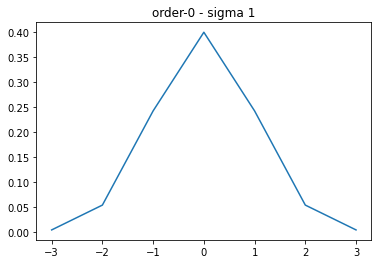

Area under the curve:  0.9999999999999999


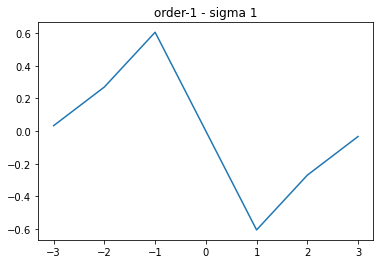

Area under the curve:  -6.938893903907228e-18


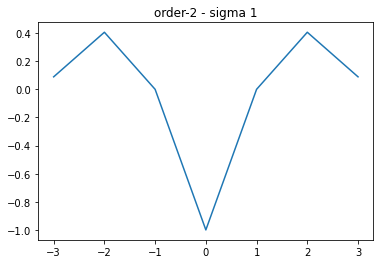

Area under the curve:  -0.010244355968446875
Sigma:  2.3


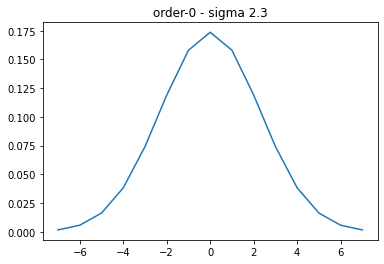

Area under the curve:  1.0


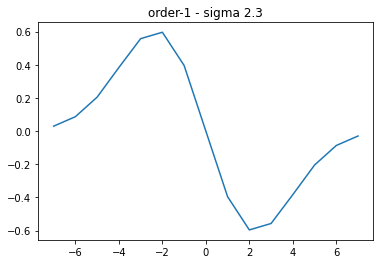

Area under the curve:  4.198030811863873e-16


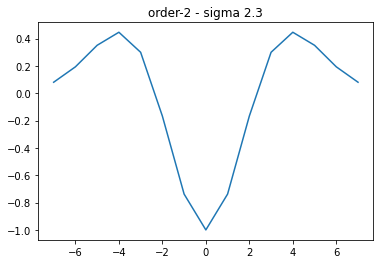

Area under the curve:  -0.06928330393791438
Sigma:  3.7


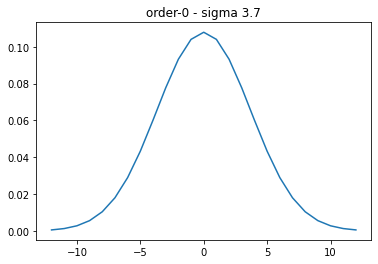

Area under the curve:  1.0


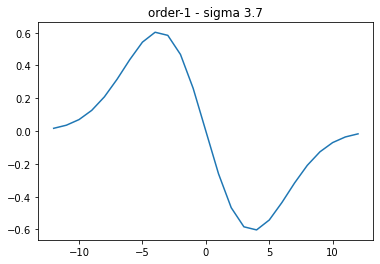

Area under the curve:  3.469446951953614e-17


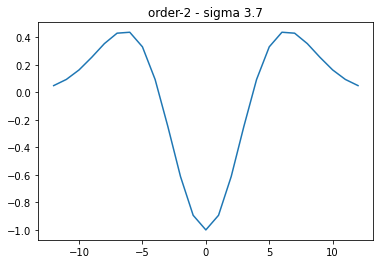

Area under the curve:  -0.08097815436081329
Sigma:  5


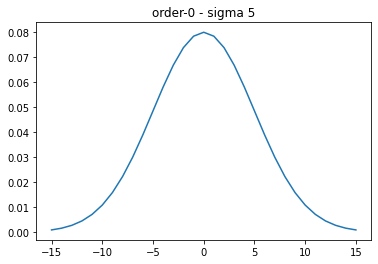

Area under the curve:  1.0000000000000002


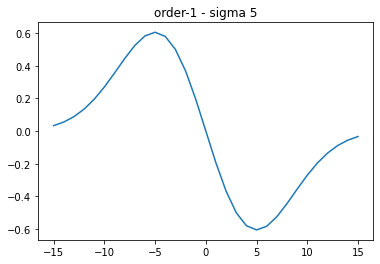

Area under the curve:  -2.7755575615628914e-17


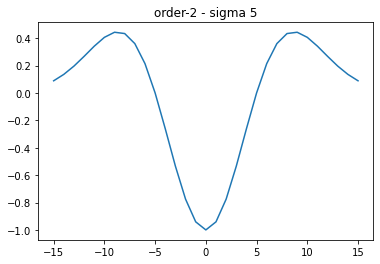

Area under the curve:  -0.2510587846838195


In [6]:
# Let's check the functions
# You must experiment with different values for sigma and sizeMask
# Write down your conclusions 
sigmas=[1,2.3,3.7,5]
sizeMask=0
for sigma in sigmas:
  print("Sigma: ",sigma)
  plotGraph(gaussianMask1D(sigma, sizeMask, order=0),title='order-0 - sigma '+str(sigma))
  plotGraph(gaussianMask1D(sigma, sizeMask, order=1), title='order-1 - sigma '+str(sigma))
  plotGraph(gaussianMask1D(sigma, sizeMask, order=2), title='order-2 - sigma '+str(sigma))

**SizeMask Values**<br/>
Del mismo modo lo hacemos para los distintos valores de tamaño de máscara

SizeMask:  7


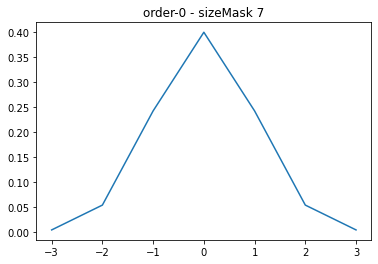

Area under the curve:  0.9999999999999999


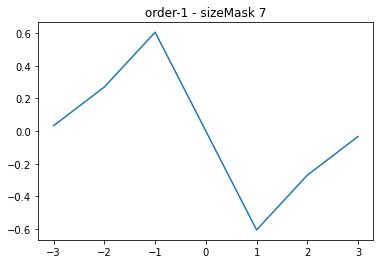

Area under the curve:  -6.938893903907228e-18


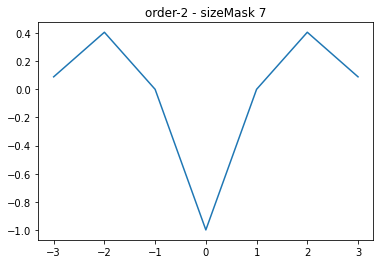

Area under the curve:  -0.010244355968446875
SizeMask:  11


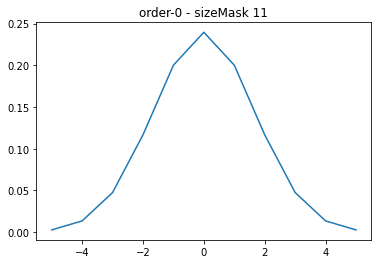

Area under the curve:  1.0


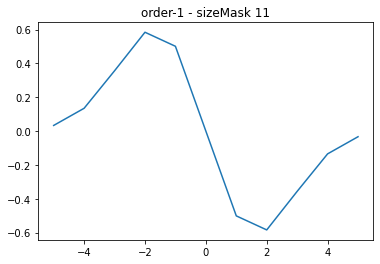

Area under the curve:  -1.734723475976807e-16


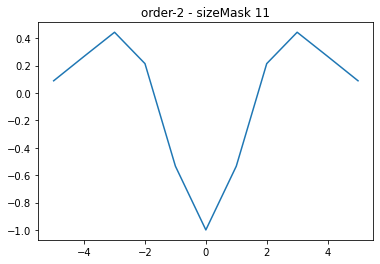

Area under the curve:  -0.042070826674228456
SizeMask:  15


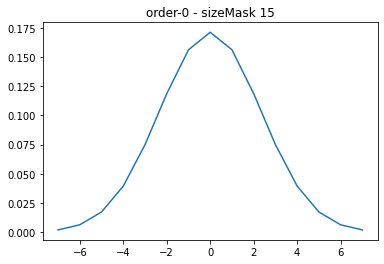

Area under the curve:  1.0


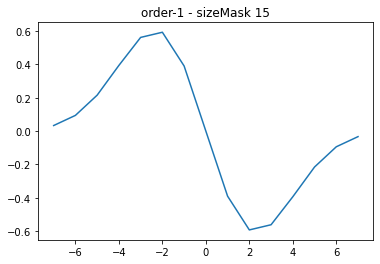

Area under the curve:  1.8735013540549517e-16


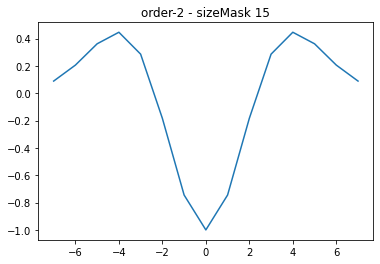

Area under the curve:  -0.08088896884852742


In [7]:
sizeMasks=[7,11,15]
sigma=0
for sizeMask in sizeMasks:
  print("SizeMask: ",sizeMask)
  plotGraph(gaussianMask1D(sigma, sizeMask, order=0),title='order-0 - sizeMask '+str(sizeMask))
  plotGraph(gaussianMask1D(sigma, sizeMask, order=1), title='order-1 - sizeMask '+str(sizeMask))
  plotGraph(gaussianMask1D(sigma, sizeMask, order=2), title='order-2 - sizeMask '+str(sizeMask))

Como podemos observar, dada la relación comentada antes entre $k$ (o el tamaño de máscara) y el valor de $\sigma$, el aumento de uno provoca un resultado similar al aumento del otro.<br/>
Además, como hemos comentado antes, los resultados de las sumas de los coeficientes son los esperados: cercanos a 1 para las discretizaciones de la gaussiana (obviamente, ya que lo forzamos) y cercanos a 0 para las discretizaciones de las derivadas.

## B)




Read an image in gray level. Smooth it applying the convolution with masks defined by a set of increasing sigma values, i.e. sigma= 0.8,1.5,3,6,12. Display all smoothed images in the same canvas. Use the OpenCV’s function `sepFilter2D()` with masks computed using your functions from (A). (1.5 points)



---



Una vez calculadas las discretizaciones de las diferentes funciones en el ejercicio 1A, ahora las utilizaremos para realizar las convoluciones.<br/>

A pesar de que las máscaras que hemos calculado previamente son máscaras 1D y las imágenes están en un espacio 2D, utilizamos la separabilidad de la Gaussiana:<br/>
<img src="https://i.stack.imgur.com/hllux.png" alt="Separability of the Gaussian"/><br/>
para reducir complejidad de la convolución de una imagen $n×n$ con una máscara $m×m$ de $O(n^2m^2$ a $O(n^2m)$ por medio de convertir una convolución 2D a dos convoluciones 1D.<br/>

Sabiendo esto, procedemos ahora a calcular diferentes convoluciones sobre una imagen de muestra, utilizando la función de OpenCV sepFilter2D con la que podemos aplicar una convolución con una máscara separable como la que tenemos:

(Aclarar que los detalles sobre el cálculo de la Laplaciana vendrán en el siguiente ejercicio)

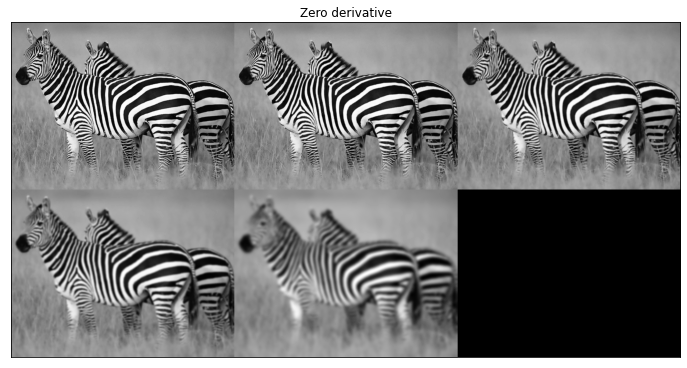

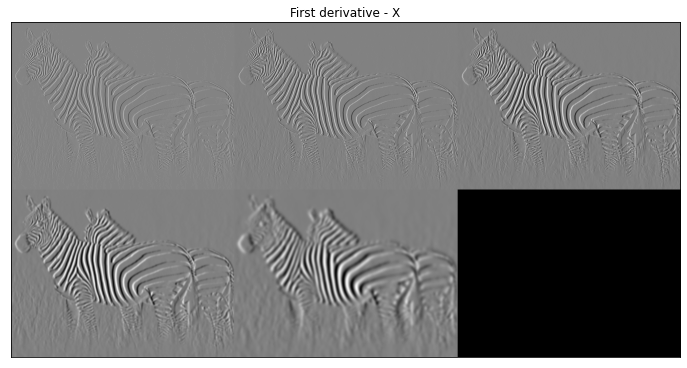

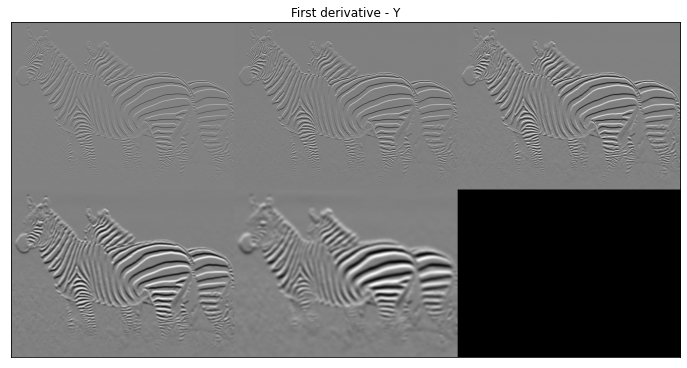

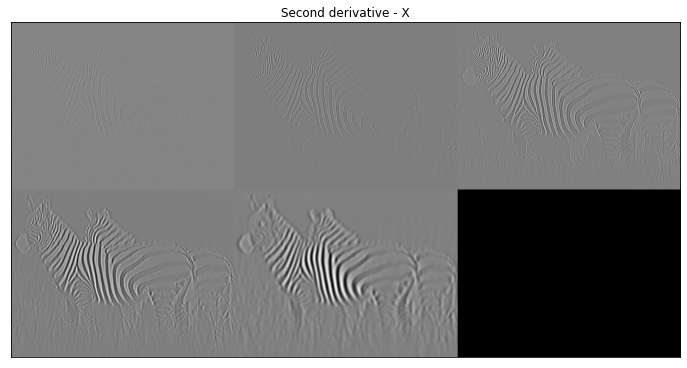

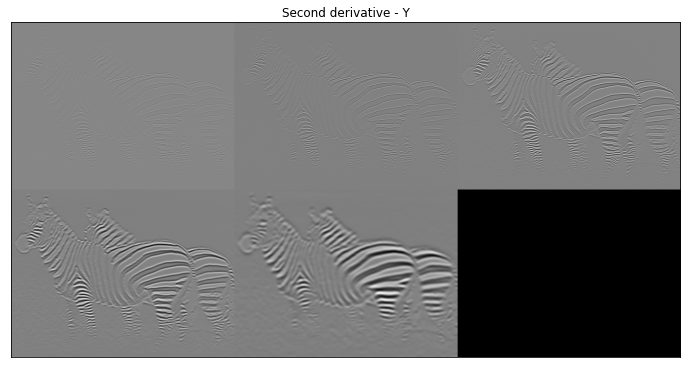

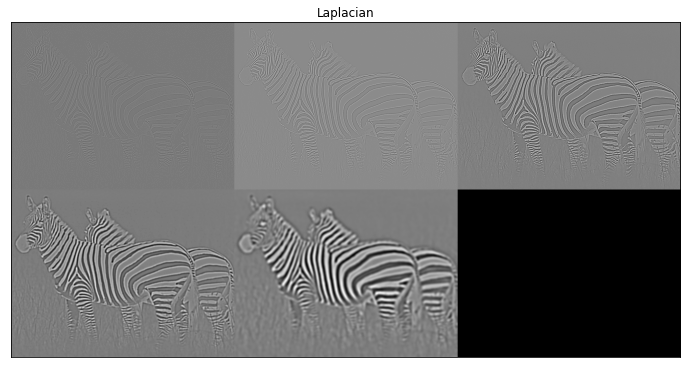

In [8]:
def my2DConv(im, sigma, orders):
  Kx=gaussianMask1D(sigma=sigma,order=orders[0])
  Ky=gaussianMask1D(sigma=sigma,order=orders[1])
  
  L = cv2.sepFilter2D(src=im,ddepth=-1, kernelX=Kx, kernelY=Ky)
  return L

im=P0.readIm('zebra.jpg', flagColor=0).astype(np.float64)
# Gaussian
vim0=[]
orders=[0,0]
for sigma in [0.8,1.5,3,6,12]:
  actual = my2DConv(im,sigma,orders)
  vim0.append(P0.rangeDisplay01(actual))

vim1=[]
orders=[1,0]
for sigma in [0.8,1.5,3,6,12]:
  actual = my2DConv(im,sigma,orders)
  vim1.append(P0.rangeDisplay01(actual))

vim2=[]
orders=[0,1]
for sigma in [0.8,1.5,3,6,12]:
  actual = my2DConv(im,sigma,orders)
  vim2.append(P0.rangeDisplay01(actual))

vim3=[]
orders=[2,0]
for sigma in [0.8,1.5,3,6,12]:
  actual = my2DConv(im,sigma,orders)
  vim3.append(P0.rangeDisplay01(actual))

vim4=[]
orders=[0,2]
for sigma in [0.8,1.5,3,6,12]:
  actual = my2DConv(im,sigma,orders)
  vim4.append(P0.rangeDisplay01(actual))

# Laplacian
vimL=[]
for sigma in [0.8,1.5,3,6,12]:
  Gxx = my2DConv(im,sigma,[2,0])
  Gyy = my2DConv(im,sigma,[0,2])
  actual = (Gxx+Gyy)
  vimL.append(P0.rangeDisplay01(actual))

P0.displayMI_ES(vim0,'Zero derivative',factor=2)
P0.displayMI_ES(vim1,'First derivative - X',factor=2)
P0.displayMI_ES(vim2,'First derivative - Y',factor=2)
P0.displayMI_ES(vim3,'Second derivative - X',factor=2)
P0.displayMI_ES(vim4,'Second derivative - Y',factor=2)
P0.displayMI_ES(vimL, 'Laplacian',factor=2)

Como vemos, con estas convoluciones obtenemos diferentes informaciones de la imagen original.
* En el caso de la convolución con la Gaussiana, lo que obtenemos es una imagen suavizada, es decir, nos estamos desplazando en el espacio de escalas de nuestra imagen.
* En el caso de la convolución con las derivadas, además de desplazarnos también en el espacio de escalas variando el valor de $σ$, estamos detectando los bordes de la imagen, es decir, los cambios de intensidad en la misma.
  * Destacar la pequeña diferencia entre la primera y la segunda derivada:<br/>
  <img src="https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MARBLE/low/edges/img23.gif"><br/>
  (Fuente: https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MARBLE/low/edges/canny.htm)<br/>
  Como podemos observar, la segunda derivada nos da un modo más preciso de encontrar los bordes ya que estos se van a situar justamente donde la segunda derivada cruce el 0 (el "peak" de la primera derivada)

## C)	

Use the OpenCV’s function `sepFilter2D()` to compute the gradient and Laplacian images using your masks from (A). Display all results in the same canvas. (1 point)



---



En este caso, procedemos a calcular el gradiente y la Laplaciana de una imagen dada. A pesar de que la Laplaciana la hemos calculado ya previamente, ahora entraremos en el detalle de su cálculo.<br/><br/>

### Gradiente
El gradiente de una imagen se define como un cambio direccional en la intensidad del color de una imagen. Es decir, el gradiente en cada píxel de la imagen, será un vector 2D cuyas componentes vendrán dadas por las derivadas con respecto a cada una de las direcciones (x e y) en ese punto.<br/>

Sin embargo, dado que no podemos representar un vector 2D para cada píxel de forma visual, utilizaremos dos representaciones por separado:<br/>
En lo que sigue:<br/>
$g_x=I*G_y*G'_x$ <br/>
$y_y=I*G'_y*G_x$
* El módulo del gradiente: $|∇I|=\sqrt{g_x^2+g_y^2}$
* La orientación del gradiente: Para ello utilizaremos la función arcotangente de dos parámetros, la cual nos devuelve el ángulo formado entre el eje $x$ positivo y la recta que conecta el $(0,0)$ con el punto $(x,y)$. $Orientation=atan2(g_y,g_x)$

De esta forma, para una imagen, representamos de forma separada las coordenadas polares del gradiente en ese píxel, siendo el módulo $r$ y la orientación el ángulo $Θ$.

### Laplaciana
Como ya sabemos, la laplaciana de la gaussiana está definida por:<br/>
$\large Δf=\frac{∂^2f}{∂x^2}+\frac{∂^2f}{∂y^2}$<br/>
por tanto, el resultado de su aplicación a una imagen vendrá dado por:<br/>
$\large L=σ^2(g_{xx}(x,y,σ)+g_{yy}(x,y,σ))$<br/>
siendo $g_{xx}$ y $g_{yy}$:
* $g_{xx}$: El resultado de aplicar la convolución con la derivada segunda de la Gaussiana en el eje x y la Gaussiana sin derivar en el eje y
* $x_{yy}$: A la inversa, la Gaussiana en el eje x y la derivada segunda de la Gaussiana en el eje y.

La normalización con el término $σ^2$ la suprimo dado que ya cada una de las máscaras está debidamente normalizada


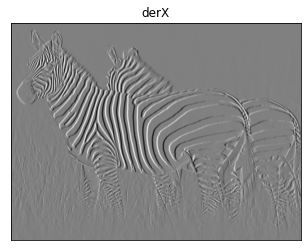

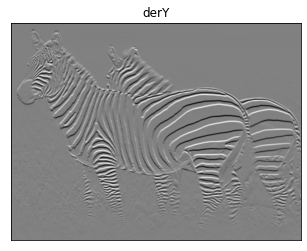

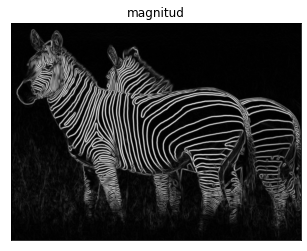

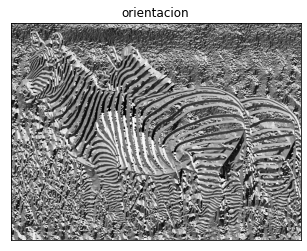

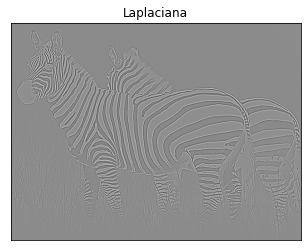

In [9]:
def gradientIM(im,sigma):
  order0 = gaussianMask1D(sigma=sigma,order=0)
  order1 = gaussianMask1D(sigma=sigma,order=1)

  dx = cv2.sepFilter2D(im,ddepth=-1,kernelX=order1,kernelY=order0)
  dy = cv2.sepFilter2D(im,ddepth=-1,kernelX=order0,kernelY=order1)
  return dx,dy

def laplacianG(im,sigma):
  order0 = gaussianMask1D(sigma=2,order=0)
  order2 = gaussianMask1D(sigma=2,order=2)

  Gxx = cv2.sepFilter2D(image,ddepth=-1,kernelX=order2,kernelY=order0)
  Gyy = cv2.sepFilter2D(image,ddepth=-1,kernelY=order2,kernelX=order0)

  G = Gxx+Gyy
  return G
  

sigma=3
image=P0.readIm('zebra.jpg',flagColor=0).astype(np.float64)
#
# The computation must be done in floating point !!!
dx,dy=gradientIM(im,sigma)
P0.displayIm(dx,'derX')
P0.displayIm(dy,'derY')
mag = np.sqrt(dx**2+dy**2)
P0.displayIm(mag,'magnitud')

orient=np.arctan2(dy,dx)
P0.displayIm(orient,'orientacion')
lap = laplacianG(image,sigma)
P0.displayIm(lap,'Laplaciana')

Analicemos cada una de las imágenes:
* **Gradiente**
  * **Magnitud**: Como podemos ver, la imagen representante de la magnitud del gradiente tiene respuestas muy altas (color blanco) allí donde hay bordes, mientras que se mantiene en negro en las zonas lisas
  * **Orientación**: Como hemos dicho antes, la orientación del gradiente nos dice hacia dónde se encuentra la variación positiva de la intensidad (hacia los colres claros) y en la representación, los colores más claros representan un ángulo mayor y los oscuros un ángulo menor

* **Laplaciana**: La Laplaciana nos da también la situación de los bordes pero de un modo diferente al gradiente, ahora la respuesta a un borde no es un aumento en la intensidad de la salida, sino un cambio de valor de positivo a negativo (o viceversa) es decir, un corte con el eje de la x.

# **Exercise-2**:  Using your functions from  previous exercises, write Python functions and show results for the following tasks (6 points).





## A) 

Build up a 4-level Gaussian pyramid for an image using Gaussian masks of size 7x7.  Display all levels  in the same canvas.  (2 points)



---



El proceso de construcción de una pirámide Gaussiana se basa en dos procesos principales.
* Blur: Simplemente, la aplicación de una convolución con una determinada máscara Gaussiana, lo cual resultará en un suavizado de la imagen
* Subsampling: Reducción del tamaño de la imagen eliminando las columnas y filas impares y quedándonos únicamente con las pares, resultando en una imagen de tamaño la mitad

Este proceso se repite iterativamente tantos niveles como deseemos, construyendo de esta forma imágenes de tamaño la mitad en cada iteración, y construyendo una pirámide.

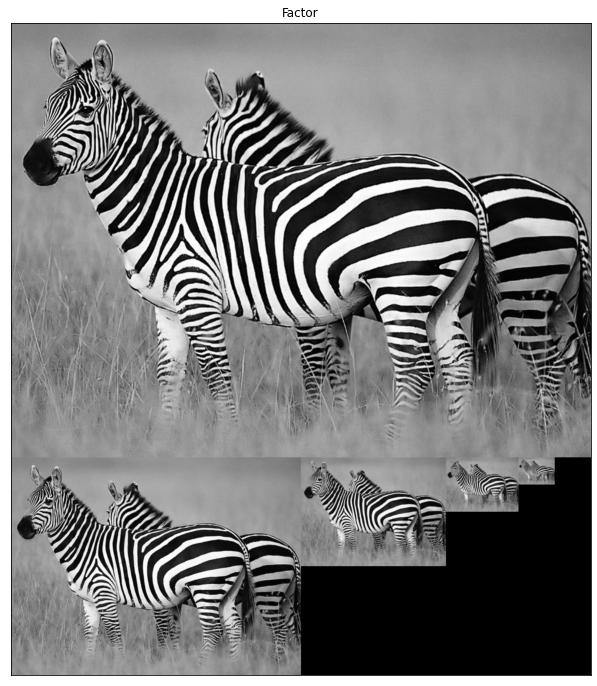

In [10]:
def pyramidGauss(im,sizeMask=7, nlevel=4):
  actual = im
  vim=[im]
  k = (sizeMask-1)/2
  sigma = k/3
  for i in range(nlevel):
    blurredMe=my2DConv(actual, sigma,[0,0])
    half = cv2.pyrDown(blurredMe)
    actual = half
    vim.append(actual)
  return vim

sizeMask=7
im=P0.readIm('zebra.jpg',flagColor=0).astype(np.float64)
# blurredMe=my2DConv(im,(sizeMask-1)/2,[0,0])
# blurredCv=cv2.GaussianBlur(im,(0,0),(sizeMask-1)/2,(sizeMask-1)/2)

pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
P0.displayMI_NES(pyrG,factor=3)

Como podemos observar, el resultado es el esperado, una pirámide en la que cada imagen tiene el tamaño de la mitad que la anterior, por tanto, una menor resolución y además, más suavizada, dado el proceso de blur aplicado.<br/>
A pesar de esto, el suavizado no es muy notable, lo cual se puede percibir mejor con el siguiente experimento, en el que comparamos las imágenes de la pirámide Gaussiana con las imágenes formadas en el mismo proceso de construcción en el que se ha suprimido el blur:

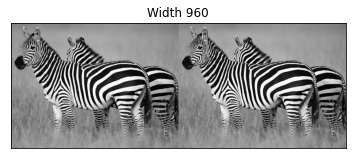

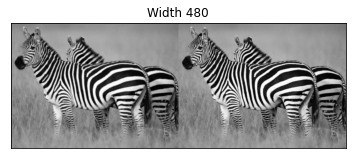

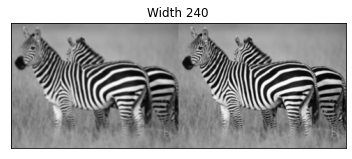

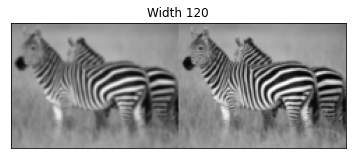

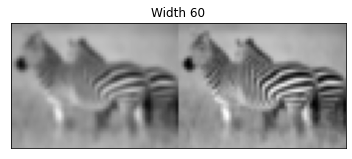

In [11]:
actualBlurred = im
actualNotBlurred = im

sizeMask=7
k = (sizeMask-1)/2
sigma = k/3
for i in range(5):
  blurred=my2DConv(actualBlurred, sigma,[0,0])
  actualBlurred = cv2.pyrDown(blurred)
  actualNotBlurred = cv2.pyrDown(actualNotBlurred)
  
  P0.displayMI_ES([actualBlurred,actualNotBlurred], title="Width "+str(len(actualBlurred[0])))


Como vemos, para un sizeMask de 7 el blur apenas es perceptible. A pesar de que esto no es realmente un problema (porque no significa que no estemos aplicando blur), puede resultar algo confuso para la percepción. Por ello vamos a aumentar el tamaño de la máscara a 15 para que los resultados sean más notables:

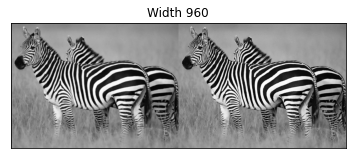

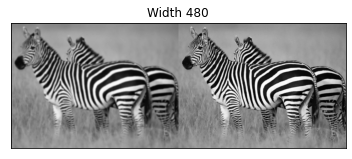

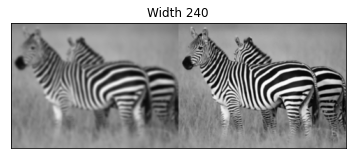

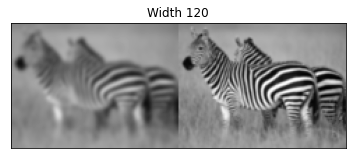

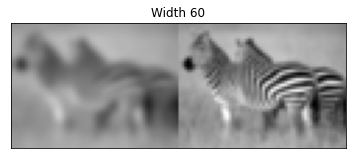

In [12]:
actualBlurred = im
actualNotBlurred = im

sizeMask=15
k = (sizeMask-1)/2
sigma = k/3
for i in range(5):
  blurred=my2DConv(actualBlurred, sigma,[0,0])
  actualBlurred = cv2.pyrDown(blurred)
  actualNotBlurred = cv2.pyrDown(actualNotBlurred)
  
  P0.displayMI_ES([actualBlurred,actualNotBlurred], title="Width "+str(len(actualBlurred[0])))


Ahora, el blur sí que es notable. Mostramos ahora la pirámide Gaussiana completa para un sizeMask de 15

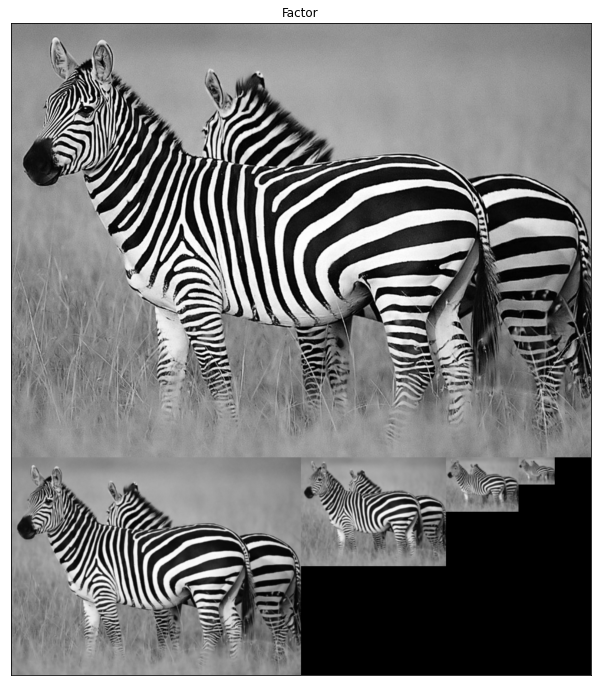

In [13]:
sizeMask=15
im=P0.readIm('zebra.jpg',flagColor=0).astype(np.float64)
# blurredMe=my2DConv(im,(sizeMask-1)/2,[0,0])
# blurredCv=cv2.GaussianBlur(im,(0,0),(sizeMask-1)/2,(sizeMask-1)/2)

pyrG = pyramidGauss(im,sizeMask=15, nlevel=4)
P0.displayMI_NES(pyrG,factor=3)

Debido a que la imagen original hace que las reducidas se vean bastante poco, no se puede percibir el blur aplicado, pero en los experimentos anteriores sí que se puede observar.

## B)

Using your code from A), implement a function to build a 4-level Laplacian pyramid.  The type of interpolation employed is now relevant. Show two examples using the images provided. Show all levels on the same canvas. (2 points) 



---



La pirámide laplaciana es también una estructura piramidal resultante del proceso iterativo de aplicar otros procesos, pero presenta diferencias con la gaussiana:

* En este caso no se realiza un proceso de downsampling, sino de expansión. En cada iteración, expandimos un nivel de la pirámide gaussiana para restarlo al siguiente nivel de la pirámide gaussiana y obtener el correspondiente de la pirámide laplaciana. Por tanto cada nivel de la pirámide laplaciana, que se construye a la inversa que la gaussiana, será la resta del mismo nivel de la gaussiana menos la expansión del nivel anterior de la gaussiana. Debemos guardar el método que se utiliza para iterpolar en la expansión de la imagen pues será vital para la reconstrucción de la misma posteriormente.

Usaremos también un sizeMask dee 15 por cohesión con lo anterior, pero realmente no sería necesario utilizar el mismo ya que en esta función volvemos a calcular la pirámide Gaussiana.

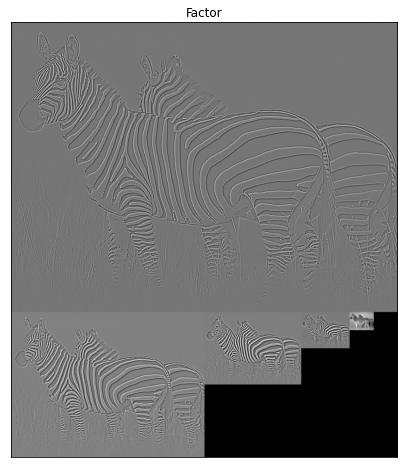

In [14]:
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR):
  pyrG = pyramidGauss(im, sizeMask=sizeMask,nlevel=nlevel)
  vimL=[P0.rangeDisplay01(pyrG[nlevel])]

  for i in range(nlevel):
    width=len(pyrG[nlevel-i][0])
    height=len(pyrG[nlevel-i])
    expandida = cv2.resize(pyrG[nlevel-i], (2*width,2*height),interpolation=flagInterp)
    result = pyrG[nlevel-i-1]-expandida
    vimL.append(P0.rangeDisplay01(result))
  return vimL

im=P0.readIm('zebra.jpg',flagColor=0).astype(np.float64)
pyrL = pyramidLap(im,sizeMask=15, nlevel=4)
P0.displayMI_NES(pyrL,factor=2)

Como vemos, obtenemos de nuevo una pirámide, en la que la imagen más pequeña corresponde al último nivel de la pirámide gaussiana y el resto a las sustracciones de las gaussianas menos las expansiones de los niveles anteriores.<br/>
De esta forma, almacenando la pirámide laplaciana podemos reconstruir la imagen original, tal y como se ve en el siguiente ejercicio.

## C) 

Implement a function to reconstruct the image encoded in the Laplacian pyramid. Take one of the pyramids from B) and verify that it is possible to obtain an exact copy of the original image. To do this, calculate the Frobenius norm of the difference between the original and the reconstructed images.(2 points)



---



Como hemos visto en el apartado anterior (siendo $i=0$ la imagen más pequeña de la pirámide laplaciana e $i=0$ la imagen más grande de la gaussiana):<br/>
$pyL[i]=pyG[nlevel-i-1]-expand(pyG[nlevel-i]), i∈\{1,...,nlevel-1\}$<br/>
y<br/>
$pyL[0]=pyG[nlevel]$<br/>
Sabiendo esto, podemos por tanto reconstruir la imagen original (y la pirámide gaussiana), sabiendo el método de interpolación usado y con la pirámide laplaciana.<br/>

El método es simplemente aplicar el proceso inverso, ahora:<br/>
$pyG[nlevel-i]=pyL[i]+expand(pyG[nlevel-i+1]), i∈\{1,...,nlevel-1\}$<br/>
Como $pyL[0]=pyG[nlevel]$, el proceso puede "arrancar" desde esta imagen, e iríamos almacenando constantemente la última imagen calculada para utilizarla como $pyG[nlevel-i+1]$ y obtener el siguiente nivel.<br/>

Así, cuando lleguemos a $pyG[0]\ (i=nlevel)$, obtendremos la imagen original con un mínimo error.<br/>

Para el proceso de expansión se debe utilizar el mismo método que hemos usado para la expansión en la construcción de la pirámide laplaciana como ya hemos comentado antes.

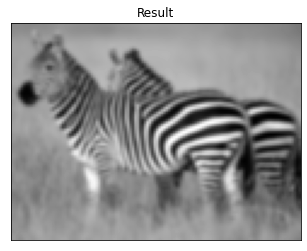

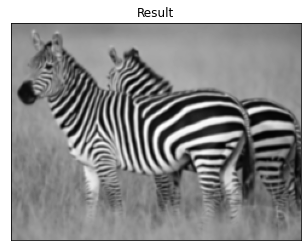

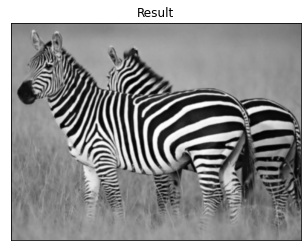

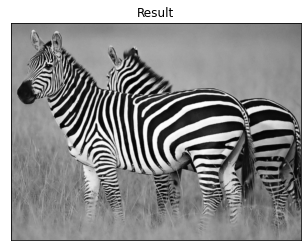

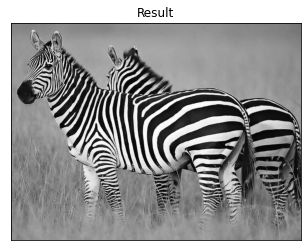

Error per pixel 2.0964055695235317e-05


In [15]:
def reconstructIm(pyL,flagInterp):
  actual = pyL[0]
  P0.displayIm(actual)
  for i in range(1,len(pyL)):
    width=len(actual[0])
    height=len(actual)
    expanded = cv2.resize(actual, (2*width,2*height),interpolation=flagInterp)
    actual = expanded+pyrL[i]
    P0.displayIm(actual)

  return actual

im=P0.readIm('zebra.jpg',flagColor=0).astype(np.float64)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
recons=reconstructIm(pyrL,cv2.INTER_LINEAR)
print('Error per pixel',np.sqrt(np.linalg.norm(im-recons, ord=2))/np.prod(im.shape))
# The final error must be 0.0

Como vemos, efectivamente, el resultado es el esperado, la imagen es similar a la original y el error por píxel es muy bajo, prácticamente 0.

# **BONUS: HYBRID IMAGES** (3 points)

This bonus section is based on the following paper about hybrid imaging: SIGGRAPH 2006 paper by Oliva, Torralba, and Schyns (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

 The goal of this bonus is to learn how the human visual system extracts information about an object depending on the distance. To do this, we construct a hybrid image from two images of different objects. By appropriately mixing part of the high frequencies of one image with part of the low frequencies of another image, we obtain a hybrid image that shows different perceptions with distance.  The smoothing of both images is the key aspect to select the high and low frequency range of each image.  The higher the sigma value, the greater the removal of high frequencies from the image. It is recommendable to choose this value separately for each of the images (see recommendations given in the article by Oliva et al.) and, in fact, more than one value may be possible. Steps to follow: 
 
1. Read the paper. 

2. Find the appropriate sigma values for each pair of images. Extract the low and high frequency images and calculate the hybrid image as the average of them. (Hint: the low frequencies must be really low).

3. Test at least two pairs of the provided ones. (Hint: Try gray level images first).

4. Use your visualization functions to display the Gaussian pyramid of the hybrid images. Explain the visual effect perceived. 



---



Una vez leída la información, procedemos ahora a implementar las funciones que actuarán como filtro paso alto y paso bajo.<br/>
Para el filtro paso bajo, utilizaremos simplemente un blur gaussiano, con un sigma que estará por definir para cada una de las fotos <br/>
Para el filtro paso alto, utilizaremos la diferencia entre la imagen original y la imagen con el filtro paso bajo aplicada (es lógico que si el blur nos da frecuencias bajas, al restarlas a la imagen original, solo nos quedan frecuencias altas)

In [16]:
def lowPassFilter(im,sigma):
  return my2DConv(im,sigma=sigma,orders=[0,0])
def highPassFilter(im,sigma):
  return im-my2DConv(im,sigma=sigma,orders=[0,0])

Definimos ahora una función que probará los valores de sigma en un rango dado para dos imágenes, una de la que se extraerán las frecuencias bajas (la cual se verá a menor nivel de detalle o más distancia) y otra las altas (la que se verá a mayor nivel de detalle o menos distancia).<br/>

En este caso, estaremos utilizando la misma máscara para ambas (una directamente y otra con la diferencia), para los casos en que esto no funcione realizaremos pruebas manualmente con diferentes máscaras para cada imagen.

In [17]:
def test(lowFreqName,highFreqName,sigmaRange):
  for sigma in np.arange(sigmaRange[0],sigmaRange[1],0.5):
    lowFreq = lowPassFilter(P0.readIm(lowFreqName,flagColor=0).astype(np.float64),sigma=sigma)
    highFreq = highPassFilter(P0.readIm(highFreqName,flagColor=0).astype(np.float64),sigma=sigma)

    combination = highFreq+lowFreq

    P0.displayMI_NES(pyramidGauss(combination,nlevel=5),title="Sigma = "+str(sigma), factor=2)

Realizamos la prueba ahora con el primer par de imágenes

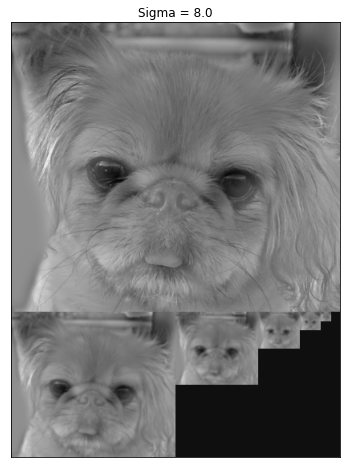

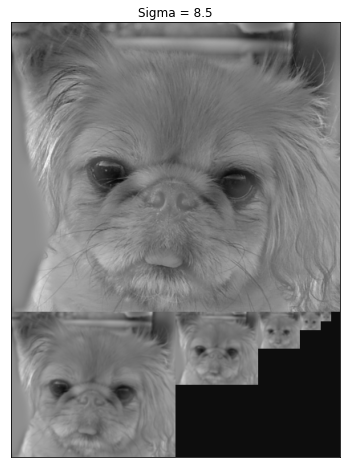

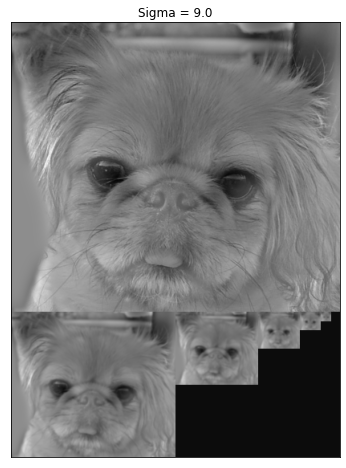

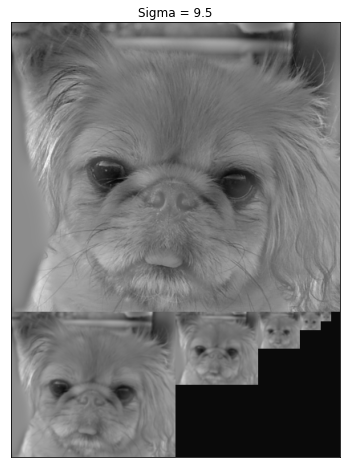

In [18]:
test('cat.bmp','dog.bmp',sigmaRange=[8.0,10.0])

Como vemos, para un valor de sigma alrededor de 8 para ambos filtros, el perro se puede apreciar en las imágenes más grandes y conforme disminuye el tamaño de las mismas, se puede apreciar el gato.

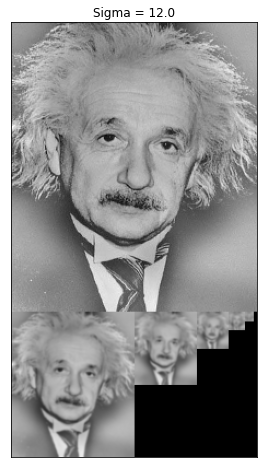

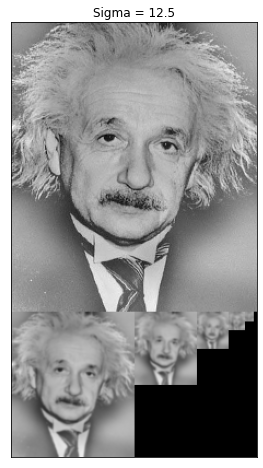

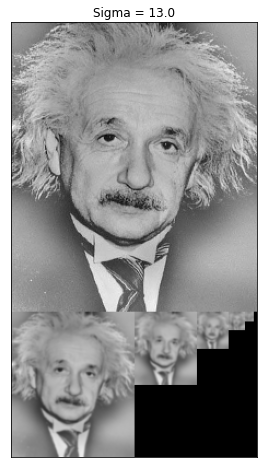

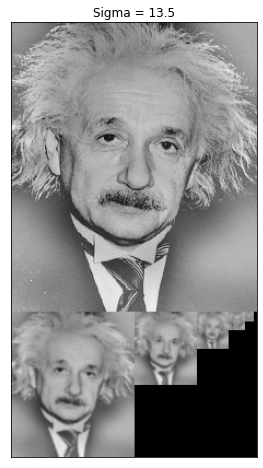

In [19]:
test('marilyn.bmp','einstein.bmp',[12.0,14.0])

Como vemos, utilizando el mismo valor de sigma para ambos filtros no se consigue un buen efecto, ya que la cara de Marilyn queda demasiado borrosa (es decir, tiene un sigma muy alto), por lo que probemos diferentes valores de sigma "manualmente".

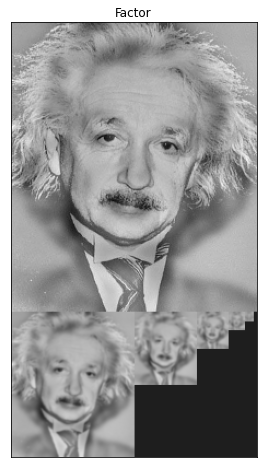

In [20]:
lowFreq = lowPassFilter(P0.readIm('marilyn.bmp',flagColor=0).astype(np.float64),sigma=4)
highFreq = highPassFilter(P0.readIm('einstein.bmp',flagColor=0).astype(np.float64),sigma=8)
combination = highFreq+lowFreq
P0.displayMI_NES(pyramidGauss(combination,nlevel=5), factor=2)

Tras probar varios valores, finalmente con un valor de sigma=4 para el filtro paso bajo y un sigma=8 para el filtro paso alto, conseguimos un buen efecto, ya que A partir de la 3ª o 4ª imagen ya se aprecia la cara de Marilyn sobre la de Einstein

Realizamos las mismas pruebas con varias imágenes más:

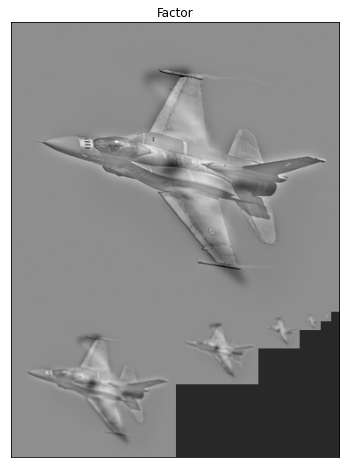

In [21]:
lowFreq = lowPassFilter(P0.readIm('bird.bmp',flagColor=0).astype(np.float64),sigma=4)
highFreq = highPassFilter(P0.readIm('plane.bmp',flagColor=0).astype(np.float64),sigma=6)
combination = highFreq+lowFreq
P0.displayMI_NES(pyramidGauss(combination,nlevel=5), factor=2)

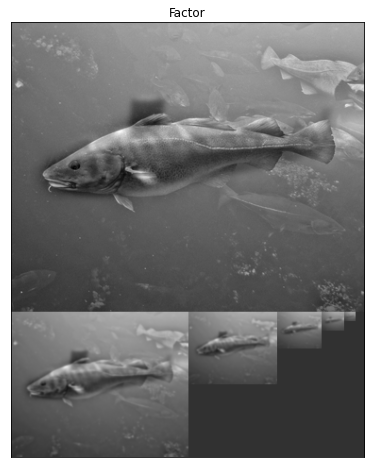

In [22]:
lowFreq = lowPassFilter(P0.readIm('submarine.bmp',flagColor=0).astype(np.float64),sigma=3)
highFreq = highPassFilter(P0.readIm('fish.bmp',flagColor=0).astype(np.float64),sigma=8)
combination = highFreq+lowFreq
P0.displayMI_NES(pyramidGauss(combination,nlevel=5), factor=2)

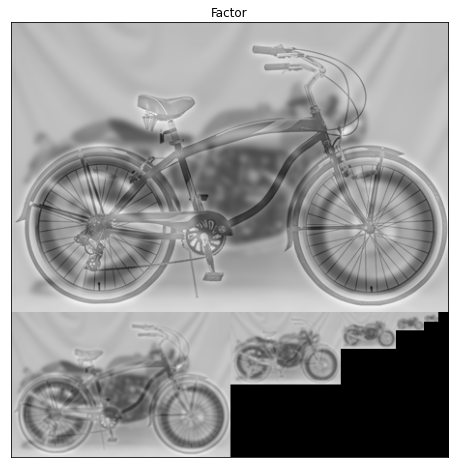

In [23]:
lowFreq = P0.rangeDisplay01(lowPassFilter(P0.readIm('motorcycle.bmp',flagColor=0).astype(np.float64),sigma=3))
highFreq = P0.rangeDisplay01(highPassFilter(P0.readIm('bicycle.bmp',flagColor=0).astype(np.float64),sigma=4))
combination = highFreq+lowFreq
P0.displayMI_NES(pyramidGauss(combination,nlevel=5), factor=2)